# 0. Introduction

In this notebook, we will perform the basic computation of a one-dimensional analysis: spectrum and light curve. We will reduce some H.E.S.S. observations of the Crab Nebula applying the 1D geometry.

In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from regions import PointSkyRegion, CircleSkyRegion
import matplotlib.pyplot as plt
from IPython.display import Image
import warnings

from gammapy.maps import MapAxis, WcsGeom, RegionGeom
from gammapy.data import DataStore, Observation
from gammapy.datasets import SpectrumDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
    ConstantTemporalModel,
    GaussianTemporalModel,
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
#from plot_utils import plot_gammapy_lc_points, plot_gammapy_sed
from gammapy.visualization import plot_spectrum_datasets_off_regions

warnings.filterwarnings("ignore")

# 1. Spectrum and Light Curve Computation of the Crab Nebula

Let us load the observations of the Crab Nebula. You can check which observation (id) belongs to which source on the last three pages of [this](https://www.mpi-hd.mpg.de/HESS/pages/dl3-dr1/hess_dl3_dr1.pdf) document and add them in the `obs_id` list below.

In [4]:
datastore = DataStore.from_dir("data/hess-dl3-dr1/")
obs_ids = [23523, 23526, 23559, 23592]
observations = datastore.get_observations(obs_ids)

## 1.1. Data reduction 

We do not need all the information in the Observation (i.e. in the DL3 file) for our analysis. As we aim to perform a one-dimensional analysis we need counts from the signal and background regions and a reduced version of the IRF components (computed at a specific offset in the camera offset). This data reduction is performed by the `SpectrumDatasetMaker`.

### 1.1.1. Energy binning and on region
First we have to define a signal extraction region, also known as on region, inside which we want to compute the spectrum. In the simplest case this is just a `CircleSkyRegion`.

In [5]:
# parameters for the spectrum extraction
# energy axes
# estimated energy for the counts histograms
energy_axis = MapAxis.from_energy_bounds(
    10, 1e5, nbin=20, per_decade=False, unit="GeV", name="energy"
)
# true energy for folding (integrating) the IRF
# advice: make this denser than the estimated energy axis
energy_true_axis = MapAxis.from_energy_bounds(
    10, 1e5, nbin=28, per_decade=False, unit="GeV", name="energy_true"
)

# on region geometry
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
#or SkyCoord.from_name("Crab Nebula")

on_region_radius = Angle("0.2 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
on_region_geom = RegionGeom.create(region=on_region, axes=[energy_axis])
# number of OFF regions
n_off_regions = 3

### 1.1.2. Exclusion mask

We will use the reflected regions method to place off regions to estimate the background level in the on region defined above. To make sure the off regions don’t contain gamma-ray emission, we create an exclusion mask. There is only one known gamma-ray source near the Crab nebula: the AGN [RGB J0521+212](http://gamma-sky.net/#/cat/tev/23) at GLON = 183.604 deg and GLAT = -8.708 deg. We create the exclusion mask around that point.

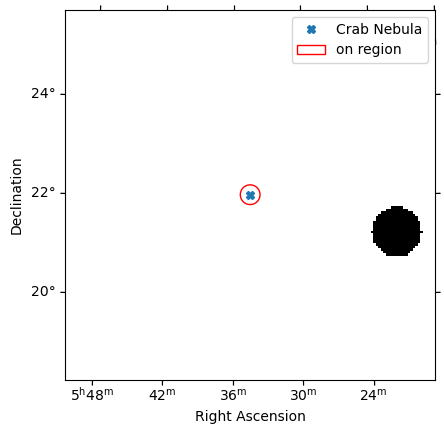

In [6]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = target_position.galactic
geom = WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot()
plt.plot(target_position.to_pixel(geom.wcs)[0],
         target_position.to_pixel(geom.wcs)[1],
         "X",label="Crab Nebula")
on_region.to_pixel(geom.wcs).plot(color="red", label="on region")
plt.legend()
plt.show()

### 1.1.3. Running the data reduction

We create an empty `SpectrumDataset` and a `Maker` to fill in the off counts and on counts of each dataset. After that we have a collection of datasets.

In [7]:
# create the blueprint for the dataset
dataset_empty = SpectrumDataset.create(
    geom=on_region_geom, energy_axis_true=energy_true_axis
)
# defines what is to be computed ("made")
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)

# finds the position of the OFF regions
region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
# "makes" the OFF counts
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder, exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

datasets = Datasets()

for observation in observations:
    # fills the ON counts and evaluates the IRF at the offset of interest
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    # fills the OFF counts
    dataset_on_off = bkg_maker.run(dataset, observation)
    #dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

### 1.1.4. Check the dataset

We can take a moment to examine our dataset and set up, for example, the correct energy threshold for the analysis.

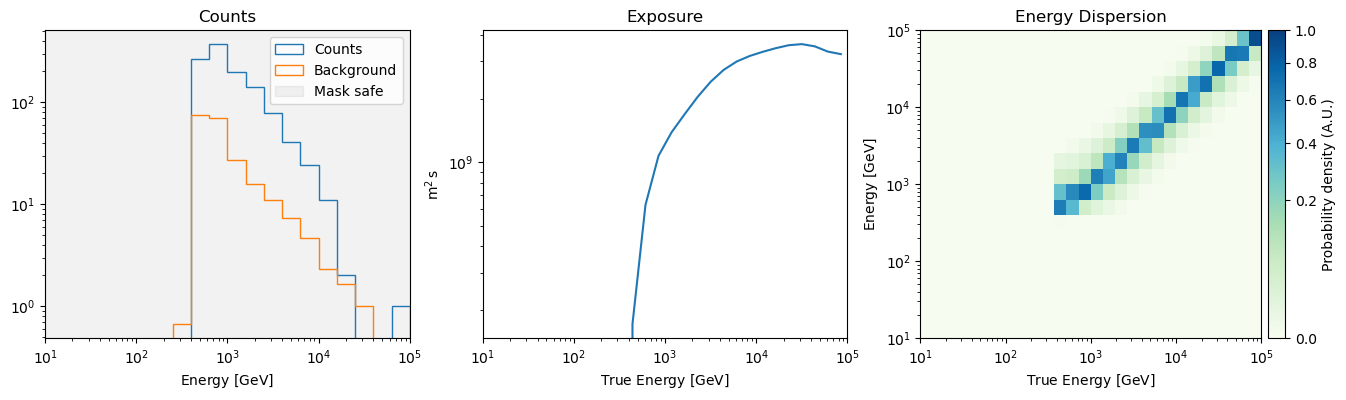

In [8]:
# to speed-up the fit - just for the average spectrum estimation - let us use the stacked dataset
dataset_stack = datasets.stack_reduce()
dataset_stack.peek()

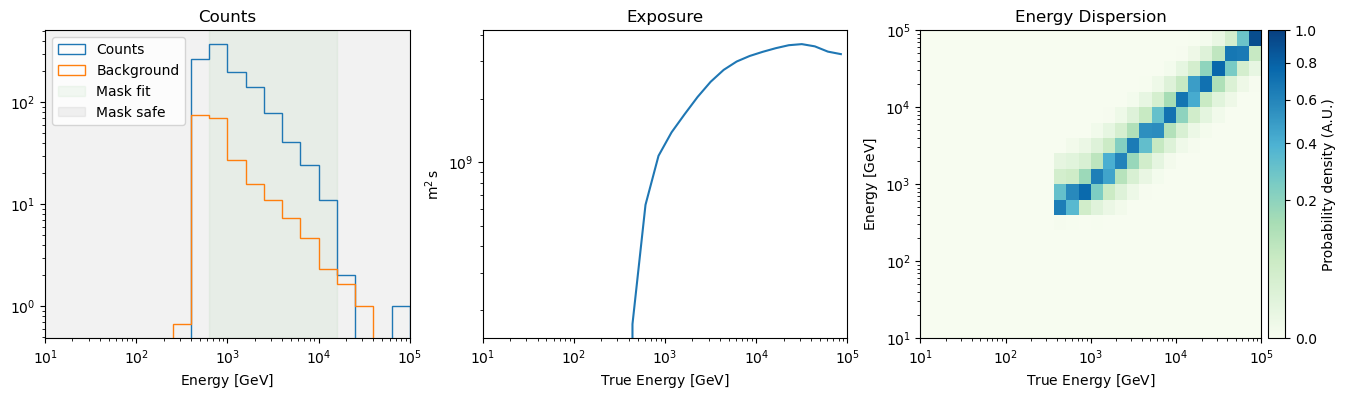

In [9]:
# apply proper minimum and maximum energy for the fit
e_min = 600 * u.GeV
e_max = 20 * u.TeV
dataset_stack.mask_fit = dataset_stack.counts.geom.energy_mask(e_min, e_max)

dataset_stack.peek()

### 1.1.4. Plot the OFF regions

To visualize which off regions the ReflectedRegionsMaker has chosen and check wether there are any overlaps with the exclusion region or on region we can plot all of them on a map.

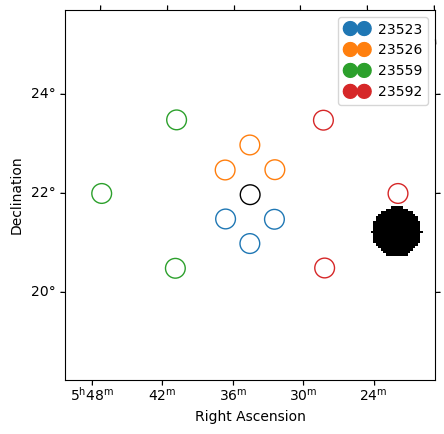

In [10]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

## 1.2. Source statistics

We can look at the overall source statistics in our signal extraction region (on region) and make the corresponding plots. For every observation we find the on counts, off counts and excess counts (on - off) and significance value of the signal. The increase of excess counts with time and the increase of significance of the signal with time should follow a linear function and a square-root function, respectively. In this case we cannot say much about it since the number of observations we have is very limited and the data can fluctuate around these functions but never follows them perfectly.

In [11]:
info_table = datasets.info_table(cumulative=True)
display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,313,241.66665649414062,16.705679866798686,71.33333587646484,131.75000294484195,131.75000294484195,nan,25487812.0,1096558464.0,1581.736764695497,1687.0000000000016,0.19788374841262302,0.045098108274797134,0.15278563531439715,20,20,wstat,300.60223807600306,214,20.0,60.0,0.3333333432674408
stacked,663,536.6666870117188,26.27096455995755,126.33333587646484,260.50000694580365,260.50000694580365,nan,102871296.0,2031342720.0,3154.4235137812757,3369.9999999999964,0.21018103533131718,0.04004957968533095,0.17013146290188688,20,20,wstat,706.2325178535923,379,40.0,120.0,0.3333333432674408
stacked,913,747.0,31.396271379691285,166.00001525878906,352.7500272132449,352.7500272132449,nan,154058400.0,2779386624.0,4732.546993609518,5056.000000000001,0.1929193732746548,0.03507625291052434,0.15784312358835395,20,20,wstat,1027.4821331419669,498,60.0,179.99998474121094,0.3333333730697632
stacked,1131,915.0,34.281356534830124,216.00003051757812,444.7500218264753,444.7500218264753,nan,171380192.0,3623836672.0,6313.811659421768,6741.999999999996,0.17913109560565818,0.034210718052581225,0.14492038238654043,20,20,wstat,1228.6723474371158,648,80.0,239.99996948242188,0.3333333730697632


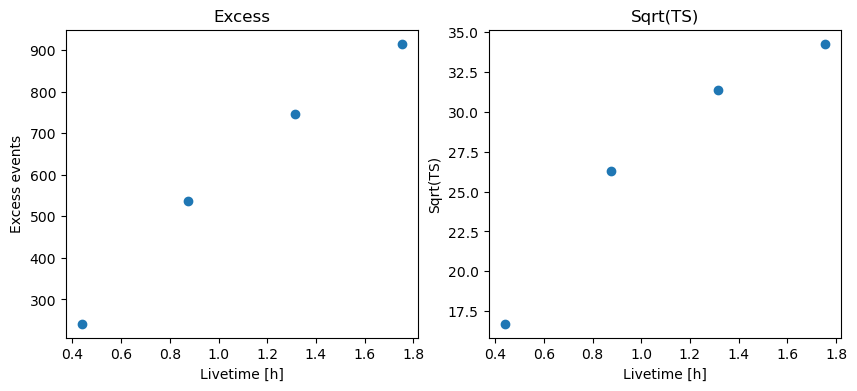

In [12]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")
plt.show()

## 1.3. Spectrum fit and flux points estimation of the Crab Nebula

To estimate the LC in Gammapy a spectral model is needed. 

### 1.3.1. Spectrum computation

We will use the one we obtain by fitting the stacked dataset. It is however also possible to do a joint fit of the datasets, meaning that we fit each of them individually but simultaneously. You can try this in the excercises, using also MAGIC data to do a joint fit. The Crab Nebula is a very well characterized source in VHE astronomy, therefore we know which spectral shape its emission follows: a power law with an exponential cutoff. The corresponding spectral model we have to choose in gammapy is the `ExpCutoffPowerLawSpectralModel`. Let's have a look at the mathematical definition: [ExpCutoffPowerLawSpectralModel](https://docs.gammapy.org/dev/user-guide/model-gallery/spectral/plot_exp_cutoff_powerlaw.html)

Similarly, for some other AGN sources it was possible to detect a spectral cut off, but note that the easiest and most common spectral shape in VHE astronomy is the simple power law. We use it for many analysis, in gammapy it is called `PowerLawSpectralModel`. You can find a full list of gammapy spectral models under the [Model Gallery](https://docs.gammapy.org/dev/user-guide/model-gallery/index.html), along with other models.

In [13]:
# let us fit the whole dataset to obtain an average specturm that we will then use for the LC computation
spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    lambda_=0.1 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)
# advice: if a LC with ULs has to be computed with this model, enlarge the amplitude range
spectral_model.parameters["amplitude"].min = 1e-15
spectral_model.parameters["amplitude"].max = 1e-7

model = SkyModel(spectral_model=spectral_model, name="crab")

# assign the model to the dataset, don't forget this!
dataset_stack.models = [model]

In [14]:
fit = Fit()
results = fit.run(datasets=dataset_stack)
print(results)
print(spectral_model)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 169
	total stat : 2.47

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

ExpCutoffPowerLawSpectralModel

type    name     value         unit      ...    max    frozen link prior
---- --------- ---------- -------------- ... --------- ------ ---- -----
         index 2.5241e+00                ...       nan  False           
     amplitude 4.0117e-11 TeV-1 s-1 cm-2 ... 1.000e-07  False           
     reference 1.0000e+00            TeV ...       nan   True           
       lambda_ 4.6555e-02          TeV-1 ...       nan  False           
         alpha 1.0000e+00                ...       nan   True           


In [15]:
# let us also compute flux points, to have a cross-check of the overall spectral shape
# I take the edges of the flux points from the estimated energy axis
energy_edges = energy_axis.edges[4:-3]

flux_points_estimator = FluxPointsEstimator(
    energy_edges=energy_edges,
    source="crab",
    selection_optional="all",
    n_sigma_ul=2,
)

flux_points = flux_points_estimator.run(datasets=dataset_stack)

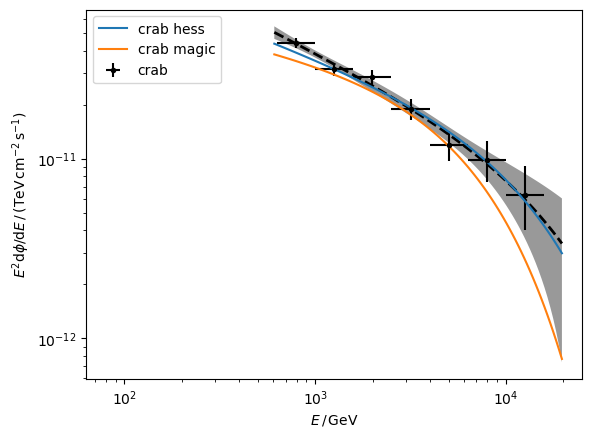

In [16]:
# make a plot of the spectrum
fig, ax = plt.subplots()
plot_kwargs = {
    "energy_bounds": [e_min, e_max],
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "xunits": u.GeV,
}

# plot spectral model
spectral_model.plot(
    ax=ax,
    ls="--",
    lw=2,
    color= "k",
    **plot_kwargs,
)
spectral_model.plot_error(ax=ax, facecolor= "k", alpha=0.4, **plot_kwargs)

flux_points.plot(
    ax=ax,
    ls="",
    markeredgewidth=0,
    color= "k",
    label="crab",
    sed_type=plot_kwargs["sed_type"],
)

create_crab_spectral_model("hess_ecpl").plot(
    **plot_kwargs,
    label="crab hess",
)

create_crab_spectral_model("magic_ecpl").plot(
    **plot_kwargs,
    label="crab magic",
)
ax.set_xlabel(r"$E\,/\,{\rm GeV}$")
ax.set_ylabel(
    r"$E^2 {\rm d}\phi/{\rm d}E\,/\,({\rm TeV}\,{\rm cm}^{-2}\,{\rm s}^{-1})$"
)
plt.legend(loc="upper left")
plt.show()

### 1.3.2. A note on spectrum and flux point estimation

**Forward folding**
The spectrum fit and the flux points are done via a so-called forward folding. Remember that we learned about the conversion from the "detector world" to the "physical world" using the IRFs? Forward folding refers to the conversion from true to estimated energy, using the energy dispersion matrix. The inverse computation is called unfolding and would require to invert the matrix to convert from estimated to true energy. The second is what we really want to do for obtaining flux points, but it is a complex task, since the migration matrix is not invertable in most cases.

**What is the use of forward folding?**
In simple words, the spectrum fit is a broadband fit to a large interval of energies (with amplitude and spectral index as free parameters), while the flux points are obtained refitting the best-fit broadband spectral shape to each bin separately (this time only the amplitude as free parameter). The result of the broadband fit is a best-fit spectral model parametrized in true energy. This is the dashed line in our plot above. The flux points and their binning, however, are defined in estimated energy. Considering this and the fact that out plot above is showing true energy on the x-axis, we can say that it is not very correct to plot it like this, since the bin edges for the flux points are actually in estimated energy. We could put it like this: Computing flux points with the forward folding technique is a sanity check for our overall spectral shape. Let's consider a case in which the emission of a source has a cutoff at high energies, but we assumed a power law shape. We can fit this to our data and not realize that there is a slight inconsistency with the data at the highest energies because the overall fitted spectrum can only tell us rough features, not the fine details. But when we compute flux points we will notice that the ones at highest energies are not fluctuating around our fit but systematically lower, indicating a cutoff of the spectrum. This is what forward-folding flux points are useful for. To have a cross check of the overall shape of the spectrum, even if we should not take them too seriously in general.

**Technically how does it work?**
To compute a spectrum with forward folding we assume a spectral shape of the source emission in the physical world (so parametrized in true energy). This spectral shape is parametrized in a model with a certain number of free parameters. To find the optimal values for the model we do the following: We start with an educated guess of the parameters and then iterate these steps...

 1. We pass it through the IRFs (the energy dispersion matrix) and predict a count value in each bin of estimated energy (see plot below).
 2. For each of these bins we have a poissonian probability distribution for the counts. We compute the likelihood as a product of all of these. The likelihood function tells us how probable the model with the corresponding parameters is, given our data. We aim to maximize it by finding the parameters for which the expected counts are closest to our actual data. 

...until we have found the maximum of the likelihood function.

To compute flux points with forward folding we repeat the procedure of the model fitting, with the difference that we do not maximize the combined likelihood of all the energy bins but maximize them separately, yielding a corrected amplitude of the emission for each bin. That way we can test the spectral characteristics on a smaller scale than is possible with the broadband spectrum.

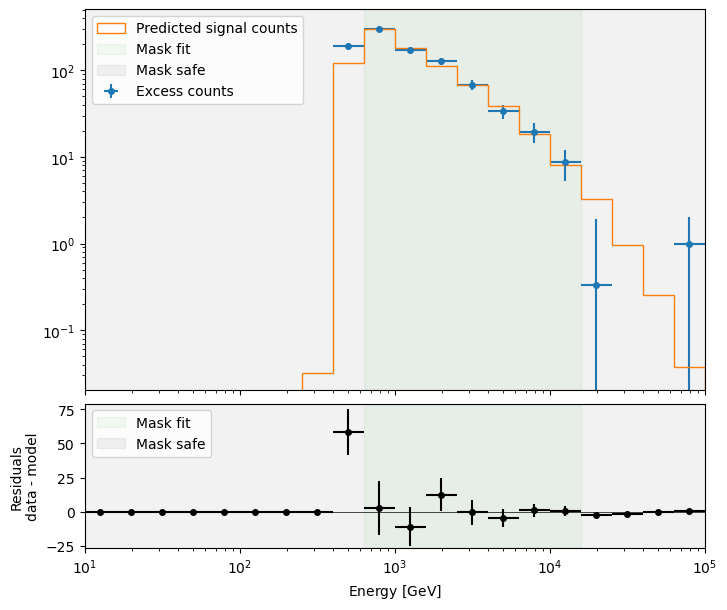

In [17]:
ax_spectrum, ax_residuals = dataset_stack.plot_fit()
#ax_spectrum.set_ylim(0.1, 40)
plt.show()

### 1.3.3 Compute the light curve

To investigate the variability of the source, we will compute a light curve with run-wise binning.

In [18]:
# assign the best-fit model to the joint datassets
datasets.models = [model]

In [19]:
# first let's compute a run-wise LC
lc_maker_run_wise = LightCurveEstimator(
    energy_edges=[e_min, e_max],
    source="crab",
    time_intervals=None,
    reoptimize=False,
    n_sigma_ul=2,
    selection_optional="all",
)
lc_run_wise = lc_maker_run_wise.run(datasets)

In [20]:
display(lc_run_wise.to_table(sed_type="flux", format="lightcurve"))

time_min,time_max,e_ref,e_min,e_max,flux,flux_err,flux_errp,flux_errn,flux_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,stat_scan,is_ul,counts,success,norm_scan
,,GeV,GeV,GeV,GeV / (TeV s cm2),GeV / (TeV s cm2),GeV / (TeV s cm2),GeV / (TeV s cm2),GeV / (TeV s cm2),,,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,4]","float64[1,4]",float64[1],float64[1],"float64[1,11]",bool[1],"float64[1,4]",bool[1],"float64[1,11]"
53343.92234009259,53343.94186555556,3981.071705534977,630.9573444801932,25118.864315095816,4.79278890414326e-08,3.7714577480641424e-09,3.843114121026425e-09,3.7041300990028037e-09,5.5784685483264346e-08,277.8902892164709,16.670041668108418,263.270901089134 .. nan,213.0594024658203 .. nan,6.313036472031689,284.20332568850256,164.1852437608719 .. 987.529609949998,False,265.0 .. nan,True,0.2 .. 4.999999999999999
53343.95421509259,53343.97369425926,3981.071705534977,630.9573444801932,25118.864315095816,4.5466209742038954e-08,3.538195484496305e-09,3.6101922352628987e-09,3.467490941423897e-09,5.283323601228401e-08,304.1764661147164,17.44065555289469,nan .. nan,nan .. nan,3.393348903720242,307.56981501843666,169.2349837933305 .. 1039.6298110143184,False,nan .. nan,True,0.2 .. 4.999999999999999
53345.9619812963,53345.98149518519,3981.071705534977,630.9573444801932,25118.864315095816,5.5452147973157016e-08,4.6722044900216916e-09,4.7827107242492316e-09,4.563695191927176e-09,6.5242492185754e-08,275.92203044985666,16.610900952382345,nan .. nan,nan .. nan,10.035331597420875,285.9573620472775,179.30434529467868 .. 615.54185613544,False,nan .. nan,True,0.2 .. 4.999999999999999
53347.913196574074,53347.93271046296,3981.071705534977,630.9573444801932,25118.864315095816,5.0650840364568437e-08,4.66524966157052e-09,4.7711616030838166e-09,4.564851987382295e-09,6.043090548702947e-08,200.42901548888517,14.157295486387405,nan .. 191.71984162447683,nan .. 152.9794158935547,8.818659325076013,209.24767481396117,128.29674161220612 .. 651.7142883298019,False,nan .. 189.0,True,0.2 .. 4.999999999999999


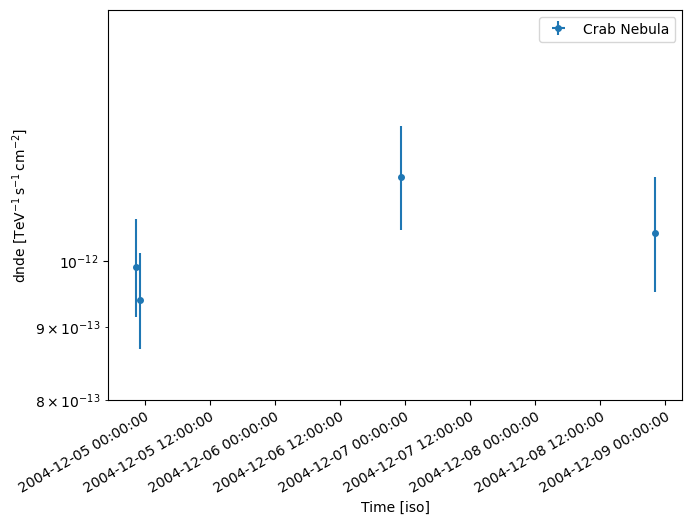

In [21]:
fig, ax = plt.subplots(
    figsize=(7, 5),
    gridspec_kw={"left": 0.16, "bottom": 0.2, "top": 0.98, "right": 0.98},
)
lc_run_wise.plot(ax=ax, marker="o", label="Crab Nebula")
ax.set_ylim(8e-13, 1.5e-12)
plt.legend()
plt.show()

### 1.3.4 Night-wise light curve

The light curve can be rebinned based on the objective of the analyzer, here we do the only other binning that makes sense for such a small dataset, a night-wise binning. We define the time intervals that cover the three nights of our observations.

In [22]:
time_intervals = [
    Time(["2004-12-04T00:00", "2004-12-05T00:00"], scale="utc"),
    Time(["2004-12-06T00:00", "2004-12-07T00:00"], scale="utc"),
    Time(["2004-12-08T00:00", "2004-12-09T00:00"], scale="utc"),
]

In [23]:
lc_maker_nightwise = LightCurveEstimator(
    energy_edges=[e_min, e_max],
    time_intervals=time_intervals,
    source="crab",
    reoptimize=False,
    n_sigma_ul=2,
    selection_optional="all",
)

nightwise_lc = lc_maker_nightwise.run(datasets)

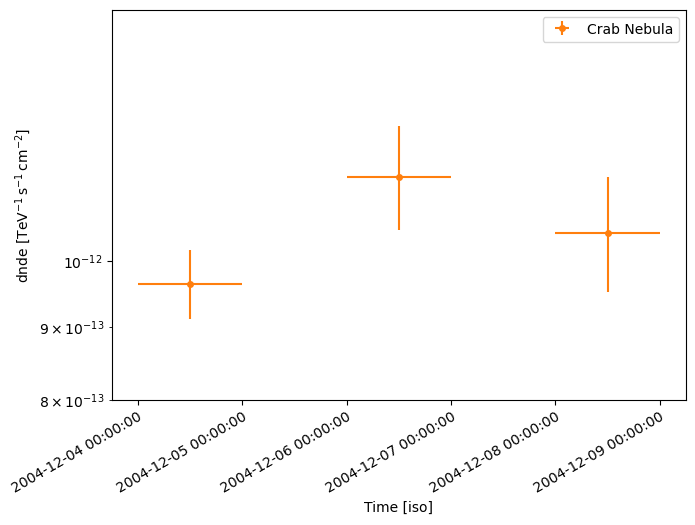

In [24]:
fig, ax = plt.subplots(
    figsize=(7, 5),
    gridspec_kw={"left": 0.16, "bottom": 0.2, "top": 0.98, "right": 0.98},
)
nightwise_lc.plot(ax=ax, marker="o", color="tab:orange", label="Crab Nebula")
ax.set_ylim(8e-13, 1.5e-12)
plt.show()

### 1.3.5. Fit the light curve

We can even fit the lightcurve with a temporal model for the emission. here we try the easiest one, a constant temporal model.

In [25]:
# Create the flux point datasets by iterating over the returned lightcurve
datasets_fp = Datasets()

for idx, fp in enumerate(lc_run_wise.iter_by_axis(axis_name="time")):
    dataset_fp = FluxPointsDataset(data=fp, name=f"time-bin-{idx}")
    datasets_fp.append(dataset_fp)

In [26]:
# Define the model:
temporal_model1 = ConstantTemporalModel()

model = SkyModel(
    spectral_model=spectral_model,
    temporal_model=temporal_model1,
    name="model-constant",
)

datasets_fp.models = model

In [27]:
fit = Fit()
result = fit.run(datasets=datasets_fp)

In [28]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully, but uncertainties are unreliable.
	nfev       : 37
	total stat : 3.11

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



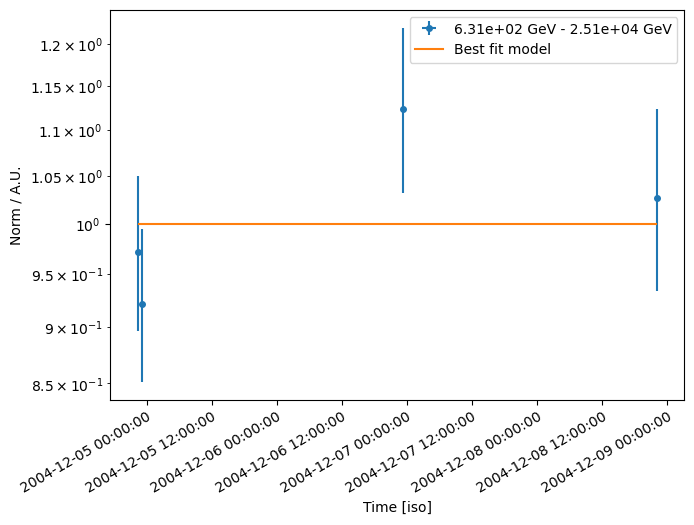

In [29]:
fig, ax = plt.subplots(
    figsize=(7, 5),
    gridspec_kw={"left": 0.16, "bottom": 0.2, "top": 0.98, "right": 0.98},
)
lc_run_wise.plot(ax=ax, sed_type="norm", axis_name="time")

time_range = lc_run_wise.geom.axes["time"].time_bounds
temporal_model1.plot(ax=ax, time_range=time_range, label="Best fit model")

#ax.set_yscale("linear")
ax.legend()

# 3. Excercises for this tutorial

## 3.1.

Load observations of the blazar PKS 2155−304 from the hess_dr1_dl3 data release, taken during a period in which the AGN was undergoing a **flaring episode** (check [here](https://www.mpi-hd.mpg.de/HESS/pages/dl3-dr1/hess_dl3_dr1.pdf)). Perform a 1D data reduction (taking into account possible differences like the exclusion masks and the coordinates of the source) and compute a spectral fit and flux points. Use a `PowerLawSpectralModel` (you can look up which parameters it gets on the gammapy documentation).

## 3.2.

Now compute a lightcurve of the emission of PKS 2155−304 in **flaring state**, using the best-fit spectral model obtained in the exercise above. Try to fit a `ConstantTemporalModel` to the lightcurve and check the goodness of the fit.